In [1]:
#Copy the code and change the name for other artists
artist_name = "Kendrick Lamar"

In [2]:
import pandas as pd
import codecs
import json
from pandas.io.json import json_normalize
import re

In [3]:
#Machine learning libraries for Text analysis
import nltk  # machine learning with text
from nltk import download as nltk_download
from nltk.corpus import stopwords, wordnet  # List of common words
from nltk.tokenize import word_tokenize  # Split text into significant forms
from nltk.stem import WordNetLemmatizer  # Reduce words to their root form
from nltk import pos_tag  # Tag words with parts of speech
from collections import defaultdict, Counter  # Dictionaries that have a backup value
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices
from textblob import TextBlob  # Sentiment analysis
from gensim.models.ldamodel import LdaModel  # Topic extraction
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS  # ngrams
from gensim.models.phrases import Phraser  # ngrams
from gensim import corpora, models, similarities  # Vectorization
import pyLDAvis
from wordcloud import WordCloud  # Create wordclouds
import matplotlib.pylab as plt

# Run next 2 cells only if you want to pull data from Genius

In [6]:
from lyricsgenius import Genius

genius = Genius('Your key here', timeout=10)
artist = genius.search_artist(artist_name, max_songs = 300) # use max_songs=10 parameter to limit to 10 songs

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Searching for songs by Kendrick Lamar...

Song 1: "HUMBLE."
Song 2: "​m.A.A.d city"
Song 3: "Swimming Pools (Drank)"
Song 4: "DNA."
Song 5: "Money Trees"
Song 6: "XXX."
Song 7: "Bitch, Don’t Kill My Vibe"
Song 8: "Poetic Justice"
Song 9: "King Kunta"
Song 10: "LOVE."
Song 11: "Backseat Freestyle"
Song 12: "Alright"
Song 13: "The Blacker the Berry"
Song 14: "Sing About Me, I’m Dying of Thirst"
Song 15: "ELEMENT."
Song 16: "LOYALTY."
Song 17: "​i (Album Version)"
Song 18: "A.D.H.D"
Song 19: "FEAR."
Song 20: "Mortal Man"
Song 21: "Wesley’s Theory"
Song 22: "​u"
Song 23: "The Heart Part 4"
Song 24: "PRIDE."
Song 25: "The Art of Peer Pressure"
Song 26: "DUCKWORTH."
Song 27: "Rigamortis"
Song 28: "HiiiPoWeR"
Song 29: "How Much a Dollar Cost"
Song 30: "Black Friday"
Song 31: "These Walls"
Song 32: "Hood Politics"
Song 33: "FEEL."
Song 34: "Sherane a.k.a Master Splinter’s Daughter"
Song 35: "The Recipe"
Song 36: "LUST."
Song 37: "​untitled 02 | 06.23.2014."
Song 38: "YAH."
Song 39: "Bitch, Don

Song 267: "Rip (Remix)"
Song 268: "Prototype"
Song 269: "Fuck A Hook"
Song 270: "Hpnotiq"
Song 271: "Respect The Classic"
Song 272: "Too Cool"
Song 273: "Thank You"
Song 274: "Higher Ground Freestyle"
Song 275: "Regulate (Freestyle)"
Song 276: "Computer Love"
Song 277: "Hovi Baby"
Song 278: "Imma G"
Song 279: "Track 12"
Song 280: "Freestyle vs Fan (On Rigamortis Beat)"
Song 281: "Look Over Your Shoulder (Demo)"
Song 282: "Man of the Hour"
Song 283: "Reebok Presents: I Am"
Song 284: "How We Do"
Song 285: "Get Throwed"
Song 286: "Talk To Me*"
Couldn't find the lyrics section. Please report this if the song has lyrics.
Song URL: https://genius.com/Terrace-martin-mortal-man-lyrics
Song 287: "All the Stars (Demo)"
Song 288: "Lunch Table (L.A. Leakers Freestyle)"
Song 289: "Sway in the Morning (Freestyle) Part 2"
Song 290: "Lyrics Contest Answers (untitled unmastered.)"
Song 291: "On My Momma"
Song 292: "Butterfly"
Song 293: "Real One"
Song 294: "Best Rap Album Acceptance Speech 2018 Grammys

In [7]:
artist_json = artist.save_lyrics()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Lyrics_KendrickLamar.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_KendrickLamar.json.


# Start here to use the data from the file on disk

In [313]:
#load the file
name_string = artist_name.replace(' ', '')
lyricsFile = "Lyrics_"+str(name_string)+".json"
with open(lyricsFile) as json_data:
    data = json.load(json_data)

# convert to dataframe
df = pd.DataFrame(data['songs'])
artist_df = df[['full_title', 'title', 'artist', 'lyrics', 'featured_artists', 'release_date']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Lyric Analysis

## Cleaning the lyrics

In [314]:
# convert everything to lower case
artist_df.lyrics = artist_df.lyrics.str.lower()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [315]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"[produced by t-minus]\n[intro]\npour up (drank), head shot (drank)\nsit down (drank), stand up (drank)\npass out (drank), wake up (drank)\nfaded (drank), faded (drank)\n\n[verse 1]\nnow i done grew up 'round some people livin' their life in bottles\ngranddaddy had the golden flask\nbackstroke every day in chicago\nsome people like the way it feels\nsome people wanna kill their sorrows\nsome people wanna fit in with the popular, that was my problem\ni was in a dark room, loud tunes\nlookin' to make a vow soon\nthat i'ma get fucked up, fillin' up my cup i see the crowd mood\nchangin' by the minute and the record on repeat\ntook a sip, then another sip, then somebody said to me\n[chorus]\nnigga, why you babysittin' only two or three shots?\ni'ma show you how to turn it up a notch\nfirst you get a swimming pool full of liquor, then you dive in it\npool full of liquor, then you dive in it\ni wave a few bottles, then i watch 'em all flock\nall the girls wanna play baywatch\ni got a swimming

In [316]:
# remove the embed, share, copy at the end of each lyric
artist_df.lyrics = artist_df.lyrics.replace(to_replace="embedshare url:copyembed:copy", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [317]:
# Remove quotes
artist_df.lyrics = artist_df.lyrics.replace(to_replace="(\u2019)", value="'", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [318]:
# convert common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="won’t", value="will not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wouldn’t", value="wouldnt", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="can’t", value="can not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="don’t", value="dont", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wanna", value="want to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="ain't", value="aint", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="gotta", value="got to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'ll", value=" will", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="lil'", value="little", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="hol'", value="hold", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [319]:
# convert more common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="it's", value="it is", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i've", value="i have", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i'm", value="i am", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="n' ", value="ng ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'n ", value="ing ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=" 'em ", value="them ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="&", value="and", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [320]:
# Remove common interjections, or singing sounds
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"aah|aagh|ayy|ooh", value="", regex=True) 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"hmm|mmm|brr", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"yeah", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"woah", value="", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
# remove verse, chorus, bridge, intro , outro anotations 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\[[^]]*\]", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
# get rid of tabs, new line, return symbols and parentheses
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=" ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\(|\)", ""], value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [323]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"  pour up  drank , head shot  drank  sit down  drank , stand up  drank  pass out  drank , wake up  drank  faded  drank , faded  drank    now i done grew up 'round some people living their life in bottles granddaddy had the golden flask backstroke every day in chicago some people like the way it feels some people want to kill their sorrows some people want to fit in with the popular, that was my problem i was in a dark room, loud tunes looking to make a vow soon that i ama get fucked up, filling up my cup i see the crowd mood changing by the minute and the record on repeat took a sip, then another sip, then somebody said to me  nigga, why you babysitting only two or three shots? i ama show you how to turn it up a notch first you get a swimming pool full of liquor, then you dive in it pool full of liquor, then you dive in it i wave a few bottles, then i watchthem all flock all the girls want to play baywatch i got a swimming pool full of liquor and they dive in it po-pool full of liquor

In [324]:
# remove any other symbols except letters, numbers and underscore
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\W", value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [325]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'  pour up  drank   head shot  drank  sit down  drank   stand up  drank  pass out  drank   wake up  drank  faded  drank   faded  drank    now i done grew up  round some people living their life in bottles granddaddy had the golden flask backstroke every day in chicago some people like the way it feels some people want to kill their sorrows some people want to fit in with the popular  that was my problem i was in a dark room  loud tunes looking to make a vow soon that i ama get fucked up  filling up my cup i see the crowd mood changing by the minute and the record on repeat took a sip  then another sip  then somebody said to me  nigga  why you babysitting only two or three shots  i ama show you how to turn it up a notch first you get a swimming pool full of liquor  then you dive in it pool full of liquor  then you dive in it i wave a few bottles  then i watchthem all flock all the girls want to play baywatch i got a swimming pool full of liquor and they dive in it po pool full of liquor

In [326]:
artist_df_clean = artist_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [327]:
# Tokenize
artist_df.lyrics = artist_df.lyrics.apply(word_tokenize)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [328]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['pour',
 'up',
 'drank',
 'head',
 'shot',
 'drank',
 'sit',
 'down',
 'drank',
 'stand',
 'up',
 'drank',
 'pass',
 'out',
 'drank',
 'wake',
 'up',
 'drank',
 'faded',
 'drank',
 'faded',
 'drank',
 'now',
 'i',
 'done',
 'grew',
 'up',
 'round',
 'some',
 'people',
 'living',
 'their',
 'life',
 'in',
 'bottles',
 'granddaddy',
 'had',
 'the',
 'golden',
 'flask',
 'backstroke',
 'every',
 'day',
 'in',
 'chicago',
 'some',
 'people',
 'like',
 'the',
 'way',
 'it',
 'feels',
 'some',
 'people',
 'want',
 'to',
 'kill',
 'their',
 'sorrows',
 'some',
 'people',
 'want',
 'to',
 'fit',
 'in',
 'with',
 'the',
 'popular',
 'that',
 'was',
 'my',
 'problem',
 'i',
 'was',
 'in',
 'a',
 'dark',
 'room',
 'loud',
 'tunes',
 'looking',
 'to',
 'make',
 'a',
 'vow',
 'soon',
 'that',
 'i',
 'ama',
 'get',
 'fucked',
 'up',
 'filling',
 'up',
 'my',
 'cup',
 'i',
 'see',
 'the',
 'crowd',
 'mood',
 'changing',
 'by',
 'the',
 'minute',
 'and',
 'the',
 'record',
 'on',
 'repeat',
 'took',


## Analysis: common 2 and 3 word phrases found in the lyrics

In [329]:
# Divide the lyrics into "sentences" so that the phrases don't straddle songs.   Each song = one sentence
sentences = []
for l in artist_df.lyrics:
    sentences.append(l)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [330]:
# Number of sentences should equal the number of songs
len(sentences)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


300

In [331]:
# check our result on the first sentence
sentences[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['nobody',
 'pray',
 'for',
 'me',
 'it',
 'been',
 'that',
 'day',
 'for',
 'me',
 'way',
 'i',
 'remember',
 'syrup',
 'sandwiches',
 'and',
 'crime',
 'allowances',
 'finesse',
 'a',
 'nigga',
 'with',
 'some',
 'counterfeits',
 'but',
 'now',
 'i',
 'am',
 'counting',
 'this',
 'parmesan',
 'where',
 'my',
 'accountant',
 'lives',
 'in',
 'fact',
 'i',
 'am',
 'downing',
 'this',
 'd',
 'ussé',
 'with',
 'my',
 'boo',
 'bae',
 'tastes',
 'like',
 'kool',
 'aid',
 'for',
 'the',
 'analysts',
 'girl',
 'i',
 'can',
 'buy',
 'your',
 'ass',
 'the',
 'world',
 'with',
 'my',
 'paystub',
 'that',
 'pussy',
 'good',
 'won',
 't',
 'you',
 'sit',
 'it',
 'on',
 'my',
 'taste',
 'bloods',
 'i',
 'get',
 'way',
 'too',
 'petty',
 'once',
 'you',
 'let',
 'me',
 'do',
 'the',
 'extras',
 'pull',
 'up',
 'on',
 'your',
 'block',
 'then',
 'break',
 'it',
 'down',
 'we',
 'playing',
 'tetris',
 'am',
 'to',
 'the',
 'pm',
 'pm',
 'to',
 'the',
 'am',
 'funk',
 'piss',
 'out',
 'your',
 'per',


In [332]:
# Look for frequently used 2 word combinations
from itertools import groupby

# Build the bigram model
bigram = Phrases(sentences)


# Find bigrams in the songs
two_word_phrases = []
i=0
while i < len(sentences): 
    bigrams = bigram[sentences[i]]
    for s in bigrams:
        if len(re.findall('_', s)) > 0:
            two_word_phrases.append(s)
    i = i + 1
two_word_phrases_df = pd.DataFrame(two_word_phrases, columns = ['Phrases'])
test = two_word_phrases_df.groupby(by = "Phrases").size().reset_index(name='counts')
test.sort_values(by = 'counts', ascending = False).head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
161,don_t,1083
609,that_s,658
691,want_to,371
738,y_all,264
109,can_t,261


In [333]:
# Looking for 3 word combinations 

# Build the trigram models
trigram = Phrases(bigram[sentences])

tri = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = trigram[bigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 1:
            tri.append(s)
    i = i + 1

tri_df = pd.DataFrame(tri, columns = ['Phrases'])
test_tri = tri_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_tri.sort_values(by = 'counts', ascending = False).head(30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
346,we_gong_be_alright,70
330,want_to_be,68
375,you_aint_got,65
366,won_t_get,54
246,pussy_and_patrón,50
284,t_kill_my_vibe,49
184,loving_you_is_complicated,47
4,a_lot_of,44
365,women_weed_and_weather,43
43,bitch_don_t_kill,39


In [334]:
fourgram = Phrases(trigram[sentences])
four = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = fourgram[trigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 2:
            four.append(s)
    i = i + 1
    
four_df = pd.DataFrame(four, columns = ['Phrases'])
test_four = four_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_four.sort_values(by = 'counts', ascending = False).head(20)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
111,we_gong_be_alright,70
93,t_kill_my_vibe,49
64,loving_you_is_complicated,47
119,women_weed_and_weather,43
10,bitch_don_t_kill,39
79,pool_full_of_liquor,38
49,hold_up_hold_up,30
71,my_vibe_bitch_don,28
121,ya_bish_ya_bish,27
26,don_t_even_smoke,25


In [335]:
len(set(tri))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


386

In [336]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
phrases_df = pd.DataFrame(columns = ['phrase', 'score'])
phrase_col = []
score_col = []
wordcount_col = []
for phrase, score in phrases.find_phrases(sentences).items():
    phrase_col.append(phrase)
    score_col.append(score)
    wordcount_col.append(len(re.findall('_', phrase)) + 1)   
phrases_df['phrase'] = phrase_col
phrases_df['score'] = score_col
phrases_df['wordcount'] = wordcount_col
phrases_df[phrases_df['wordcount'] > 2].sort_values(by='wordcount', ascending = False).head(50)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,phrase,score,wordcount
685,club_with_the_homies,17.713469,4
730,it_with_the_glocks,15.704404,4
235,screaming_in_the_hotel,241.100000,4
602,front_of_the_county,55.709884,4
157,live_in_a_world,12.856218,4
265,look_in_the_mirror,40.127601,4
675,venting_in_the_safe,1298.230769,4
294,head_of_the_police,47.043902,4
706,welcome_to_the_wild,264.621951,4
302,illuminated_by_the_hand,119.061728,4


In [337]:
from nltk import ngrams
tgs = nltk.ngrams(sentences[0],5)
fdist = nltk.FreqDist(tgs)
d = Counter()
ngrams_df = pd.DataFrame(columns = ['N-gram', 'Count'])
ngrams_col = []
Count_col = []
for k, v in fdist.items():
    d[k] = v
    ngrams_col.append(k)
    Count_col.append(v)
ngrams_df['N-gram'] = ngrams_col
ngrams_df['Count'] = Count_col
ngrams_df.sort_values(by='Count', ascending = False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,N-gram,Count
180,"(hold, up, bitch, sit, down)",14
181,"(up, bitch, sit, down, hold)",14
182,"(bitch, sit, down, hold, up)",14
205,"(down, hold, up, hold, up)",10
204,"(sit, down, hold, up, hold)",10
177,"(bitch, be, humble, hold, up)",10
189,"(up, little, bitch, be, humble)",8
190,"(little, bitch, be, humble, hold)",8
214,"(hold, up, hold, up, hold)",8
188,"(hold, up, little, bitch, be)",8


In [338]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [nobody, pray, for, me, it, been, that, day, f...
1      [if, pirus, and, crips, all, got, along, they,...
2      [pour, up, drank, head, shot, drank, sit, down...
3      [i, got, i, got, i, got, i, got, loyalty, got,...
4      [uh, me, and, my, niggas, tryna, get, it, ya, ...
                             ...                        
295    [dropped, 40, for, a, glock, 40, that, s, a, h...
296    [my, name, is, lucy, kendrick, you, introduced...
297    [gangsta, gangsta, gangsta, x, 5, when, i, kic...
298    [from, the, very, heart, of, me, belief, becom...
299    [so, they, looking, for, me, they, don, t, kno...
Name: lyrics, Length: 300, dtype: object

In [339]:
stop_words = stopwords.words("english")
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in stop_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [340]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [nobody, pray, day, way, remember, syrup, sand...
1      [pirus, crips, got, along, probably, gun, end,...
2      [pour, drank, head, shot, drank, sit, drank, s...
3      [got, got, got, got, loyalty, got, royalty, in...
4      [uh, niggas, tryna, get, ya, bish, ya, bish, h...
                             ...                        
295    [dropped, 40, glock, 40, hood, discount, acces...
296    [name, lucy, kendrick, introduced, kendrick, u...
297    [gangsta, gangsta, gangsta, x, 5, kick, kick, ...
298    [heart, belief, becomes, action, distractions,...
299    [looking, know, waiting, right, ama, sit, wind...
Name: lyrics, Length: 300, dtype: object

In [343]:
lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Perform the lemmatization
#artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])#
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [344]:
remove_words = ['like', 'get', 'got', 'know', 'say']
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in remove_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [345]:
artist_df.lyrics[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['nobody',
 'pray',
 'day',
 'way',
 'remember',
 'syrup',
 'sandwich',
 'crime',
 'allowance',
 'finesse',
 'nigga',
 'counterfeit',
 'counting',
 'parmesan',
 'accountant',
 'life',
 'fact',
 'down',
 'ussé',
 'boo',
 'bae',
 'taste',
 'kool',
 'aid',
 'analyst',
 'girl',
 'buy',
 'as',
 'world',
 'paystub',
 'pussy',
 'good',
 'sit',
 'taste',
 'blood',
 'way',
 'petty',
 'let',
 'extra',
 'pull',
 'block',
 'break',
 'play',
 'tetri',
 'pm',
 'pm',
 'funk',
 'piss',
 'per',
 'diem',
 'hate',
 'em',
 'funk',
 'quit',
 'bm',
 'still',
 'ride',
 'mercedes',
 'funk',
 'quit',
 'season',
 'still',
 'great',
 'funk',
 'left',
 'stroke',
 'go',
 'viral',
 'right',
 'stroke',
 'put',
 'little',
 'baby',
 'spiral',
 'soprano',
 'c',
 'keep',
 'high',
 'note',
 'level',
 'bitch',
 'humble',
 'hold',
 'bitch',
 'sit',
 'hold',
 'little',
 'hold',
 'little',
 'bitch',
 'humble',
 'hold',
 'bitch',
 'sit',
 'hold',
 'sit',
 'little',
 'sit',
 'little',
 'bitch',
 'humble',
 'hold',
 'hold',
 'b

In [346]:
# Create the list of words and their frequency (corpus)
from gensim import corpora
pyLDAvis.enable_notebook()
#dictionary = corpora.Dictionary(artist_df.lyrics )
dictionary = corpora.Dictionary(artist_df.lyrics)
corpus = [dictionary.doc2bow(text) for text in artist_df.lyrics ]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [347]:
import gensim
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.015*"nigga" + 0.013*"fuck" + 0.009*"go" + 0.007*"shit" + 0.006*"bitch" + 0.006*"make" + 0.006*"see" + 0.006*"want" + 0.006*"aint" + 0.006*"time"')
(1, '0.011*"want" + 0.011*"love" + 0.010*"nigga" + 0.008*"one" + 0.007*"see" + 0.007*"bitch" + 0.007*"aint" + 0.007*"come" + 0.007*"feel" + 0.007*"make"')
(2, '0.014*"nigga" + 0.008*"go" + 0.008*"feel" + 0.007*"kill" + 0.007*"see" + 0.006*"cause" + 0.006*"gong" + 0.006*"shit" + 0.006*"alright" + 0.006*"make"')


In [348]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [349]:
dictionary

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [350]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

#sentences = Text8Corpus(datapath('testcorpus.txt'))
artist_df.lyrics1 = [wd for wd in artist_df.lyrics]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(artist_df.lyrics1, min_count=3, threshold=10)

# Construct bigram
print(bigram[artist_df.lyrics[0]])

['nobody_pray', 'day', 'way', 'remember', 'syrup', 'sandwich', 'crime', 'allowance', 'finesse', 'nigga', 'counterfeit', 'counting', 'parmesan', 'accountant', 'life', 'fact', 'down', 'ussé', 'boo', 'bae', 'taste', 'kool_aid', 'analyst', 'girl', 'buy', 'as', 'world', 'paystub', 'pussy', 'good', 'sit', 'taste', 'blood', 'way', 'petty', 'let', 'extra', 'pull', 'block', 'break', 'play', 'tetri', 'pm', 'pm', 'funk', 'piss', 'per', 'diem', 'hate', 'em', 'funk_quit', 'bm', 'still', 'ride', 'mercedes', 'funk_quit', 'season', 'still', 'great', 'funk', 'left_stroke', 'go', 'viral', 'right_stroke', 'put', 'little', 'baby', 'spiral', 'soprano', 'c', 'keep', 'high_note', 'level', 'bitch_humble', 'hold', 'bitch_sit', 'hold_little', 'hold_little', 'bitch_humble', 'hold', 'bitch_sit', 'hold_sit', 'little', 'sit_little', 'bitch_humble', 'hold_hold', 'bitch_sit', 'hold_hold', 'little', 'bitch_humble', 'little', 'bitch', 'hold', 'bitch_sit', 'hold_hold', 'hold_hold', 'humble_hold', 'hold_sit', 'hold_hold'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-350-00f6d1d42edf>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  artist_df.lyrics1 = [wd for wd in artist_df.lyrics]


# Wordcloud

In [351]:
artist_df.lyrics = artist_df.lyrics.apply(lambda x: " ".join(x))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [352]:
artist_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date
0,HUMBLE. by Kendrick Lamar,HUMBLE.,Kendrick Lamar,nobody pray day way remember syrup sandwich cr...,[],2017-03-30
1,​m.A.A.d city by Kendrick Lamar (Ft. MC Eiht),​m.A.A.d city,Kendrick Lamar,pirus crips along probably gun end song seem w...,"[{'api_path': '/artists/4637', 'header_image_u...",2012-10-22
2,Swimming Pools (Drank) by Kendrick Lamar,Swimming Pools (Drank),Kendrick Lamar,pour drank head shot drank sit drank stand dra...,[],2012-07-31
3,DNA. by Kendrick Lamar,DNA.,Kendrick Lamar,loyalty royalty inside dna cocaine quarter pie...,[],2017-04-14
4,Money Trees by Kendrick Lamar (Ft. Jay Rock),Money Trees,Kendrick Lamar,uh nigga tryna ya bish ya bish hit house lick ...,"[{'api_path': '/artists/1403', 'header_image_u...",2012-10-22


In [353]:
# Create an object that converts strings into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 20000 , min_df=0.01, ngram_range= (1,1))

# Convert the text column to a sparse matrix

data_dtm = vectorizer.fit_transform(artist_df.lyrics)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [354]:
# Create a dataframe of terms and frequencies
# Get the frequency of each term

term_frequencies = data_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

term_df = pd.DataFrame(columns=["term","frequency"], data=frequent_terms)

# Sort the dataframe

term_df.sort_values(by="frequency", ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


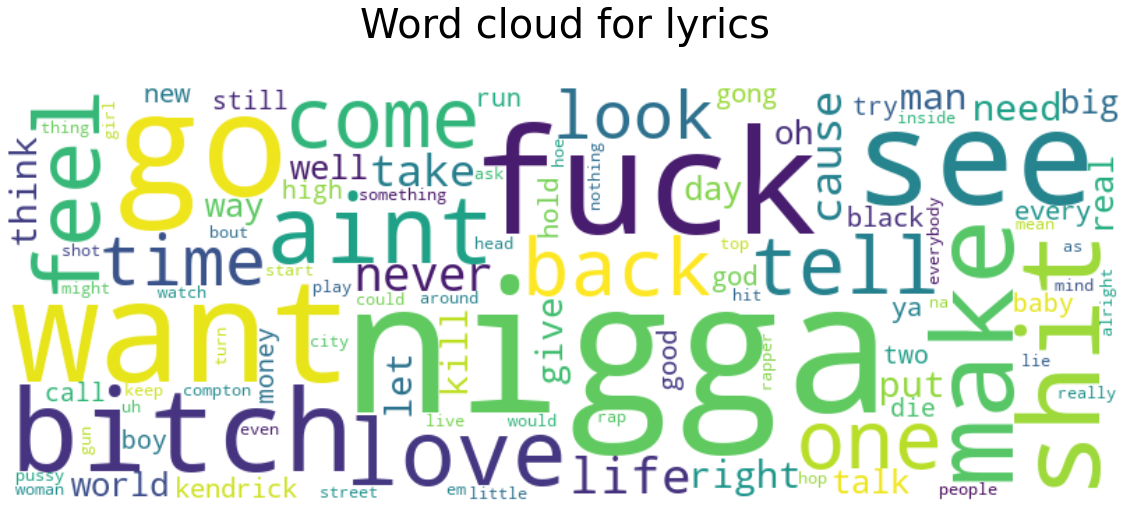

In [355]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, background_color="white",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))
plt.title("Word cloud for lyrics", fontsize = 40, pad = 50 )
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment

In [356]:
# Assign sentiment to each lyric
artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-356-d312c35c4e1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)


In [357]:
artist_df.sort_values(by="sentiment", ascending=False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date,sentiment
9,LOVE. by Kendrick Lamar (Ft. Zacari),LOVE.,Kendrick Lamar,damn love lust damn u give run money nobody on...,"[{'api_path': '/artists/526832', 'header_image...",2017-04-14,0.357727
247,I'm Da Man by Kendrick Lamar,I’m Da Man,Kendrick Lamar,see man tellthem roger bitch shatter glass try...,[],None,0.342187
65,Poe Mans Dreams (His Vice) by Kendrick Lamar (...,Poe Mans Dreams (His Vice),Kendrick Lamar,smoke good eat good live good smoke good eat g...,"[{'api_path': '/artists/343', 'header_image_ur...",2011-07-02,0.327244
62,Opposites Attract (Tomorrow W/O Her) by Kendri...,Opposites Attract (Tomorrow W/O Her),Kendrick Lamar,hurt people love u love people hurt u hurt peo...,"[{'api_path': '/artists/2554', 'header_image_u...",2010-09-14,0.302083
270,Respect The Classic by Kendrick Lamar,Respect The Classic,Kendrick Lamar,pimp pimp hooray pimp pimp hooray hooray pimp ...,[],2016-08-08,0.300860
228,Comments on 2014 Grammys by Kendrick Lamar,Comments on 2014 Grammys,Kendrick Lamar,macklemore win best rap album well deserve man...,[],None,0.300000
140,Prayer by Kendrick Lamar,Prayer,Kendrick Lamar,born february 24th 1970 day deliver would buil...,[],None,0.297181
136,Determined by Kendrick Lamar (Ft. Ash Riser),Determined,Kendrick Lamar,want describe discovery simplest term possible...,"[{'api_path': '/artists/12414', 'header_image_...",2009-12-31,0.292234
287,Lunch Table (L.A. Leakers Freestyle) by Kendri...,Lunch Table (L.A. Leakers Freestyle),Kendrick Lamar,cool thirty two shot clip thirty four little n...,[],2014-09-24,0.289158
190,Hub City's Wild Side by Kendrick Lamar,Hub City’s Wild Side,Kendrick Lamar,welcome wild side hub city wild side tec fly h...,[],None,0.276298


In [370]:
artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")
artist_df = artist_df.sort_values(by = "Datetime")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-370-20a3b369a7a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


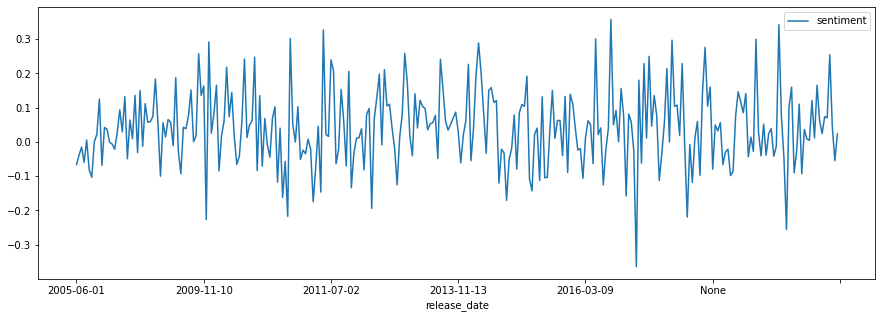

In [371]:
plt = artist_df.plot(x = 'release_date', y = 'sentiment', figsize=(15, 5))